## Deep Learning with Python ３章勉強ノート（その２）
ManningのMEAP（出版前の本のできた部分から読めるサービス）でTensorFlowとTheanoの両方に対応したラッパーツールkerasの作者Francois Chollet氏の「Deep Learning with Python」が発売されました。

３章では、機械学習でよく使われる以下の手法をニューラルネットワークを使って実現する方法を紹介しています。
- 二値分類（binary classification）
- マルチクラス分類(multi-class classification)
- 線形回帰(regression)

ここでは、マルチクラス分類をSageのjupyterノートブックで試しながら、Deep Learningへの理解を深めたいと思います。

### 前準備
jupyterノートブックで使用するnumpy、pandas、seabornとmatplotlibをインポートします。

In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt 

%matplotlib inline

次に、kerasで使うパッケージをインポートします。

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


## 使用するデータについて
kerasで用意されているロイター記事のデータセットを使用します。

このデータセットは、11,228個のロイターのニュースワイヤーを46のトピックにラベル付けしたもので、内部表現形式はIMDMと同じです。

In [3]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(nb_words=10000)

In [4]:
print len(train_data), len(test_data)

8982 2246


In [5]:
print np.array(train_data[10]).flatten()

[   1  245  273  207  156   53   74  160   26   14   46  296   26   39   74
 2979 3554   14   46 4689 4329   86   61 3499 4795   14   61  451 4329   17
   12]


In [6]:
print train_labels[:10], max(train_labels)

[3, 4, 3, 4, 4, 4, 4, 3, 3, 16] 45


IMDB同様、元の単語を知るために辞書をロードします。

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [8]:
print [reverse_word_index[idx] for idx in train_data[10]]

['the', 'federal', 'gain', 'only', 'growth', 'lt', 'they', 'meeting', 'year', 'reuter', 'company', 'did', 'year', 'an', 'they', 'ground', 'edouard', 'reuter', 'company', '608', '653', '1987', 'had', 'autumn', 'objectives', 'reuter', 'had', 'profits', '653', 'pct', 'dlrs']


### データのベクトル化
IMDBと同様に、単語のインデックスを、インデックスが含まれている場合１、それ以外は０の長さ10000のベクトルに変えます。 それをすべてのニュースワイヤーに適応してニュースワイヤー数x１００００のマトリックスを作ります。

ラベルも長さ４６のベクトルのインデックスに対応する箇所が１で他は０のone-hot形式に変換します。

In [9]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [10]:
# our vectorized training data
x_train = vectorize_sequences(train_data)
# our vectorized test data
x_test = vectorize_sequences(test_data)

In [11]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## モデルの作成
隠しユニットを64持つ２層のニューラルネットの後に長さ46、活性化関数softmax（複数のカテゴリに属する確率）の層を追加します。

IMDBとの違いは、損失関数loss=categorical_crossentropyを使っているところです。

In [12]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10000))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [15]:
history = model.fit(partial_x_train, partial_y_train, nb_epoch=20, batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s - loss: 2.6517 - acc: 0.4744 - val_loss: 1.7180 - val_acc: 0.6390
Epoch 2/20
7982/7982 [==============================] - 1s - loss: 1.4278 - acc: 0.7028 - val_loss: 1.2764 - val_acc: 0.7120
Epoch 3/20
7982/7982 [==============================] - 1s - loss: 1.0549 - acc: 0.7761 - val_loss: 1.1031 - val_acc: 0.7650
Epoch 4/20
7982/7982 [==============================] - 1s - loss: 0.8360 - acc: 0.8212 - val_loss: 1.0090 - val_acc: 0.7700
Epoch 5/20
7982/7982 [==============================] - 1s - loss: 0.6691 - acc: 0.8558 - val_loss: 0.9429 - val_acc: 0.8040
Epoch 6/20
7982/7982 [==============================] - 1s - loss: 0.5345 - acc: 0.8899 - val_loss: 0.9156 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s - loss: 0.4339 - acc: 0.9107 - val_loss: 0.8833 - val_acc: 0.8190
Epoch 8/20
7982/7982 [==============================] - 1s - loss: 0.3509 - a

## 収束の様子を可視化
モデルの収束の様子をpandasのグラフ機能を使って可視化します。

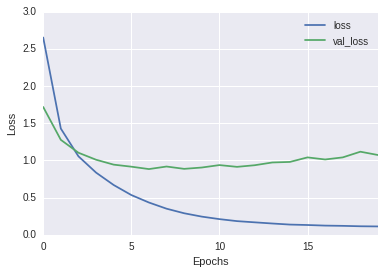

In [16]:
d = pd.DataFrame(history.history)
ax = d[['loss', 'val_loss']].plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

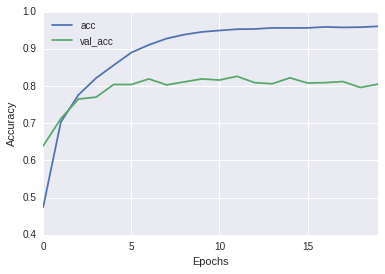

In [17]:
d = pd.DataFrame(history.history)
ax = d[['acc', 'val_acc']].plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

## テストデータの予測
損失関数のグラフからエポック数=9を過ぎた時点から検証用の損失関数が増加するため、エポック数を9として、モデルを作り直します。

求まったモデルを使ってテスト用データのトピックインデックスを求めてみましょう。

In [18]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10000))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, one_hot_train_labels, nb_epoch=9, batch_size=512,
          validation_data=(x_test, one_hot_test_labels))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 8982 samples, validate on 2246 samples
Epoch 1/9
8982/8982 [==============================] - 2s - loss: 2.4271 - acc: 0.5480 - val_loss: 1.6239 - val_acc: 0.6687
Epoch 2/9
8982/8982 [==============================] - 1s - loss: 1.3094 - acc: 0.7239 - val_loss: 1.3306 - val_acc: 0.7070
Epoch 3/9
8982/8982 [==============================] - 1s - loss: 0.9930 - acc: 0.7828 - val_loss: 1.1544 - val_acc: 0.7551
Epoch 4/9
8982/8982 [==============================] - 1s - loss: 0.7817 - acc: 0.8369 - val_loss: 1.0513 - val_acc: 0.7711
Epoch 5/9
8982/8982 [==============================] - 1s - loss: 0.6183 - acc: 0.8705 - val_loss: 0.9927 - val_acc: 0.7747
Epoch 6/9
8982/8982 [==============================] - 1s - loss: 0.4919 - acc: 0.8984 - val_loss: 0.9587 - val_acc: 0.7912
Epoch 7/9
8982/8982 [==============================] - 1s - loss: 0.3928 - acc: 0.9159 - val_loss: 0.9594 - val_acc: 0.7858
Epoch 8/9
8982/8982 [==============================] - 1s - loss: 0.3225 - acc: 0.93

In [19]:
results

[0.95519519149460963, 0.7907390917186109]

### 予測結果
精度は、79%となりました。各ニュースワイヤーのトピックはどのように求まったのか、ちょっと見てみましょう。

predictionsは、行がニュースワイヤ数、列が４６のマトリックスとして返されます。
softmaxによる最初のニュースワイヤの予測値をみると、トピック３が最大で、予測値のsumは１になっているのが分かります。

In [20]:
predictions = model.predict(x_test)

In [21]:
# predictionsのshape
print predictions.shape
# 最初の予測結果
print predictions[0]
# 予測結果の合計（sum）
print np.sum(predictions[0])
# 最大値のインデックス
print np.argmax(predictions[0])

(2246, 46)
[  7.53664153e-06   1.34718081e-04   1.99637834e-05   9.55809236e-01
   3.79515737e-02   4.32788420e-06   1.25317129e-05   5.83551855e-06
   1.48489734e-03   2.70062424e-06   5.42695161e-05   1.51785876e-04
   3.25456749e-05   3.89894194e-05   1.84202247e-04   3.13290002e-05
   1.42355263e-03   1.32210203e-04   3.91197636e-06   9.60704172e-04
   1.90850056e-04   2.45589297e-04   1.43316620e-05   2.46405107e-05
   5.28965893e-06   1.81419455e-04   1.65399044e-07   8.30094723e-06
   2.97593260e-06   4.39715586e-05   3.66236090e-05   7.43845594e-05
   6.02972705e-06   2.41537691e-06   1.62834098e-04   1.14636341e-05
   6.94813061e-05   4.69296392e-05   8.92769185e-06   3.87983251e-04
   8.95249741e-07   1.60912987e-05   2.76358696e-06   6.82055486e-07
   2.97098580e-07   7.81322615e-06]
1.0
3


数値で見ると分かりづらいですが、グラフにプロットすると、３がダントツだと分かります。

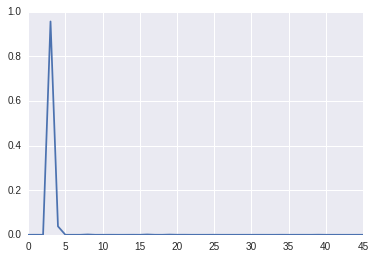

In [22]:
plt.plot(predictions[0])
plt.show()

求まった精度がどの程度のものなのか、知るためにランダムに選択した場合の、精度を計算してみましょう。

およそ18％となり、これに対して79%は結構いけてる言えるでしょう。

In [23]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)
0.18655387355298308

0.18655387355298308

## Scikit-LearnのSVCで試す
Scikit-Learnのサポートベクターマシーン（SVM）のカテゴリ版SVCを使って、どの程度の精度が出るか試してみます。

学習に要する時間は、MacBookAirのdocker（２GB,　２CPU）で３０分程度かかりました。時間をかけた割には精度は77%なのでちょっと残念でした。

In [12]:
from sklearn.datasets import load_digits
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics

In [13]:
C = 1.
kernel = 'rbf'
gamma  = 0.01

In [23]:
classifier = SVC(C=C, kernel=kernel, gamma=gamma)
classifier.fit(x_train, train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
predicted = classifier.predict(x_test)

In [26]:
print predicted[:10], test_labels[:10]

[ 3 16  1 16 13  3  3  3  3  3] [3, 10, 1, 4, 4, 3, 3, 3, 3, 3]


In [27]:
print metrics.confusion_matrix(test_labels, predicted)
print metrics.accuracy_score(test_labels, predicted)

[[ 7  2  0 ...,  0  0  0]
 [ 0 86  0 ...,  0  0  0]
 [ 0  6  9 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  2  0  0]
 [ 0  1  0 ...,  0  4  0]
 [ 0  0  0 ...,  0  0  1]]
0.773820124666
